## Import libraries

In [1]:
#import libraries
import promptlib
import tkinter as tk
from tkinter import filedialog
import os
import random
from PIL import Image, ImageFont, ImageDraw
from faker import Faker
import numpy as np
import pandas as pd
import pytesseract
import cv2
import easyocr
import shutil
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
import paddleocr
from paddleocr import PaddleOCR, draw_ocr
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import logging
import time

# Set the logging level to CRITICAL to suppress all logging messages
logging.getLogger("ppocr").setLevel(logging.CRITICAL)

2024-04-28 20:57:43.127727: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## create a list of PHI identifiers

In [2]:
phi_list=['patient_id','Name','dob','phone','email','address','ssn','medical_rec_num']

## functions for data prep used during the capstone

In [3]:
# function to generate fake data dataframe

def fakedat_gen(n):
    Faker.seed(random.randint(0, sys.maxsize))
    fake=Faker()
    
    #code to randomly generate integer 1 or 2 which will determine the faker gender
    
    f_phi_ds=pd.DataFrame(columns=['patient_id','Sex','Name','dob','phone','email','address','ssn','Test Date','Facility'])
    for ii in range(n):
    
        #generate random integers 1 or 2
        fake_int=random.randint(1,2)
        
        #fake empty phi dictionary
        f_phi=dict()

        # start generating fake data and saving it into the empty dictionary
        f_phi['patient_id']=fake.uuid4()
        if fake_int==1:
            f_phi['Sex']='M'
            f_phi['Name']= fake.name_male()
            
        else:
            f_phi['Sex']='F'
            f_phi['Name']= fake.name_female()
            
        f_phi['dob']=(fake.date_time_between(start_date='-85y',end_date='-10y')).strftime('%Y-%m-%d')
        f_phi['phone']=fake.phone_number()
        f_phi['email']=fake.email()
        f_phi['address']=fake.address()
        f_phi['ssn']=fake.ssn()
        f_phi['Test Date']=(fake.date_time_between(start_date='-2y',end_date='-0y')).strftime('%Y-%m-%d %H:%M:%S')
        f_phi['Facility']=fake.company()
        f_phi['medical_rec_num'] = fake.random_int(min=100000, max=999999)
        
        #append the data for a fake person to the dataframe
        f_phi_ds=pd.concat([f_phi_ds,pd.DataFrame([f_phi])],ignore_index=True)
    
    #returning the dataframe with fake data for the n number of patients
    return(f_phi_ds)

# function to randomly chose datapoints for a fake patient to be entered in the X-ray file
def data_sel(fake):
    cols=random.randint(1,fake.shape[1])
    rand_dat=fake.sample(n=1,axis=0).sample(n=cols,axis=1)
    dum_dat=rand_dat.apply(lambda c: f"{c.name}:{c.values}", axis=0)
    return(dum_dat)

#function to insert the data and save the file at a user selected location
def add_text(file_loc,fk, add_phi, dest_file):
    
    #chosing the fonts of the data to be inserted
    dat_font = ImageFont.truetype("Verdana.ttf",12)
    
    #list to store the PHI type inserted in the image file. Assumption is that all files do not have PHI
    phi_type=[0]

    my_image=Image.open(file_loc)
    
    if add_phi==1:
        image_editable = ImageDraw.Draw(my_image)
        i=0
        dum_val=data_sel(fk)
        phi_type = dum_val.index.tolist()
                
        for v in dum_val:
            image_editable.text((4,4+i), v, 250, font=dat_font)
            i=i+20
            
    if add_phi==0:
        
        image_editable = ImageDraw.Draw(my_image)
        i=0
        dum_val=data_sel(fk)
        filtered_series = dum_val[~dum_val.index.isin(phi_list)]
        phi_type = [0]
               
        for v in filtered_series:
            image_editable.text((4,4+i), v, 250, font=dat_font)
            i=i+20 
            
    my_image.save(dest_file)
    return(phi_type)

    
def make_folders(par_loc):
    #check if folder exists, if yes then delete it and create a new folder with the same name
    if os.path.exists(folder_ds_name_path):
        shutil.rmtree(folder_ds_name_path)  

    os.mkdir(folder_ds_name_path)

## Preparation of Dataset

#### Prompt the user for the location of the x-ray images without PHI (downloaded from NIH Clinical DB)

In [4]:
prompter = promptlib.Files()
dir=prompter.dir()

In [5]:
## calculate the number of files in the selected folder##
files=os.listdir(dir) #dir
num_files= len(files)

#having even number of files in the dataset as it would help to assign PHI as well as splitting the dataset for training and testing
if num_files%2==1:
    num_files-=1



In [6]:
## randomly select 300 files from num_files and use it for model building
files_select=300

#select the number of files
dir_files=random.sample(files,files_select)

#miniumum number of times a category of files should exist (PHI/non-PHI))
min_occ=int(0.3*len(dir_files))

phi=random.randint(min_occ,len(dir_files)-min_occ)
non_phi=len(dir_files) - phi

dir_files_cat=[1]*phi + [0]* non_phi

In [12]:
#randomly shuffling the phi/non_phi data tags and then associate them to the file names

random.shuffle(dir_files_cat)

#get file names from the selected directory
ds_file_dict=dict(zip(dir_files,dir_files_cat))
phi_tag_dict=ds_file_dict.copy()

In [13]:
#### create a folder to store the newly created synthetic image files
dir_dat=os.path.dirname(dir)

folder_ds_name='Image Dataset'

folder_ds_name_path=os.path.join(dir_dat,folder_ds_name)


In [14]:
#check if folder exists, if yes then delete it and create a new folder with the same name
if os.path.exists(folder_ds_name_path):
    shutil.rmtree(folder_ds_name_path)  

os.mkdir(folder_ds_name_path)

#### generate fake data for all the files

In [15]:

fk_data=fakedat_gen(len(dir_files))

In [16]:
phi_data_dict=phi_tag_dict.copy()
for ii in ds_file_dict:
    
    source_file=os.path.join(dir,ii)
    dest_file=os.path.join(folder_ds_name_path,ii)
    phi_data_dict[ii]=add_text(source_file,fk_data,ds_file_dict[ii],dest_file)

    

In [17]:
phi_tag=pd.DataFrame.from_dict(ds_file_dict, orient='index',columns=['value'])

phi_tag.reset_index(inplace=True)
phi_tag.columns = ['file_name', 'Value']

#location where phi_tag file will be saved
phi_tag_path=os.path.join(folder_ds_name_path,'phi_tag.csv')

# save this dataframe as csv at the same location
phi_tag.to_csv(phi_tag_path)

## Model Building and Preprocessing of the data

In [22]:
# fetch the files from Image Dataset and append the folder path to file names
model_ds_files=sorted([file for file in os.listdir(folder_ds_name_path ) if not file.endswith(".csv")])

#append the file name to folder path
model_ds_loc=list(map(lambda x:folder_ds_name_path  +'/' + x, image_files))
model_ds_loc

['/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028178_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028181_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028182_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028184_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028186_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028187_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028191_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028192_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028205_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028211_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028215_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028216_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028223_000.png',

In [23]:
phi_dict_key_list=sorted(list(phi_tag_dict.keys()))
phi_tag_dict_sorted=dict(sorted(phi_tag_dict.items()))
phi_tag_dict_sorted

{'00028178_000.png': 0,
 '00028181_000.png': 1,
 '00028182_000.png': 0,
 '00028184_000.png': 0,
 '00028186_000.png': 1,
 '00028187_000.png': 0,
 '00028191_000.png': 1,
 '00028192_000.png': 1,
 '00028205_000.png': 0,
 '00028211_000.png': 0,
 '00028215_000.png': 0,
 '00028216_000.png': 0,
 '00028223_000.png': 0,
 '00028225_000.png': 0,
 '00028229_000.png': 0,
 '00028234_000.png': 1,
 '00028243_000.png': 1,
 '00028251_000.png': 0,
 '00028254_000.png': 1,
 '00028256_000.png': 1,
 '00028257_000.png': 0,
 '00028265_000.png': 0,
 '00028274_000.png': 1,
 '00028279_000.png': 0,
 '00028281_000.png': 0,
 '00028287_000.png': 0,
 '00028288_000.png': 0,
 '00028292_000.png': 1,
 '00028295_000.png': 0,
 '00028296_000.png': 1,
 '00028297_000.png': 0,
 '00028298_000.png': 0,
 '00028300_000.png': 0,
 '00028311_000.png': 0,
 '00028317_000.png': 0,
 '00028319_000.png': 0,
 '00028324_000.png': 1,
 '00028328_000.png': 1,
 '00028337_000.png': 1,
 '00028339_000.png': 0,
 '00028344_000.png': 0,
 '00028346_000.p

In [24]:
model_ds_phi_list=[]

for file in model_ds_files:
    if file in phi_dict_key_list:
        #print(f"{file} - {phi_dict_key_list}")
        model_ds_phi_list.append(phi_tag_dict[file])

model_ds_phi_list 

[0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,


In [25]:
#initializing lists to store images and image_phi_tags
img_files=[]
img_tag=[]

#### pre processing of files

In [26]:
# preprocess the files

for im in model_ds_files:
    #open the image and store it in the image list
    file_name_path=os.path.join(folder_ds_name_path,im)
    img=cv2.imread(file_name_path)

    #preprocess the image and normalize pixel values
    img=cv2.resize(img,(512,512))
    img=img/255
    img_files.append(img)
       
    #entering tags in a list
    img_tag.append(phi_tag_dict[im])

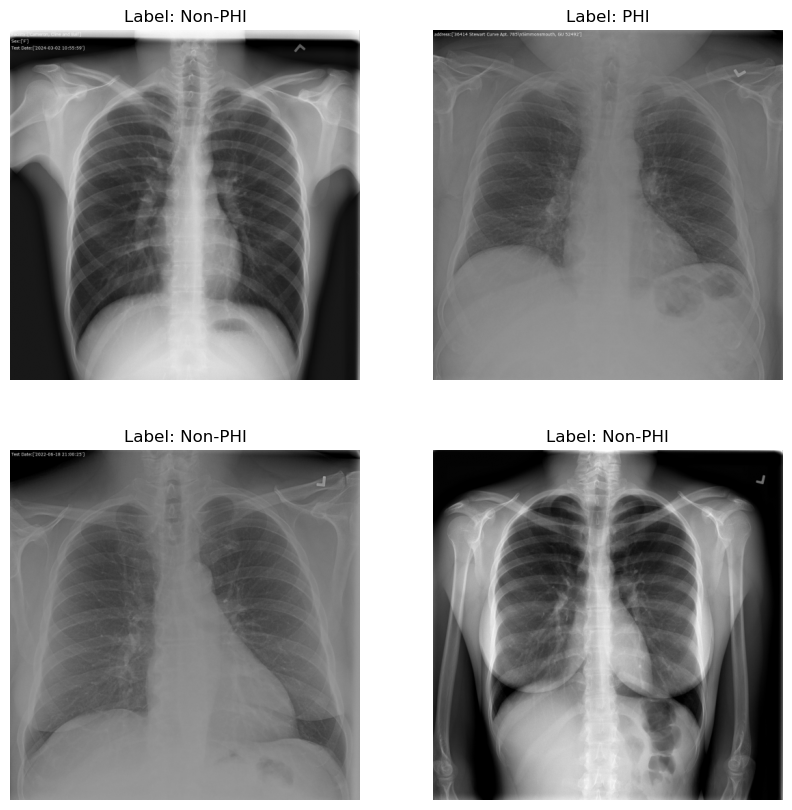

In [48]:
# saving the preprocessed files in the initialized arrays
img_tag=np.array(model_ds_phi_list)
img_files=np.array(img_files)

# Display a few images
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(img_files[i])
    if img_tag[i]==1:
        label='PHI'
    if img_tag[i]==0:
        label='Non-PHI'
    plt.title(f"Label: {label}")
    plt.axis("off")

plt.show()


### Model Training and Evaluation

### CNN Model

In [29]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Create a simple CNN model
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(512, 512, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Optional dropout for regularization
model.add(layers.Dense(1, activation='sigmoid'))  # Binary classification for PHI or non-PHI

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(img_files, img_tag, test_size=0.3, random_state=100)

In [31]:
print(f"x_train - {len(x_train)}")
print(f"y_train - {len(y_train)}")
print(f"x_test - {len(x_test)}")
print(f"y_test - {len(y_test)}")

x_train - 210
y_train - 210
x_test - 90
y_test - 90


Epoch 1/8
7/7 [==============================] - 44s 6s/step - loss: 1.9512 - accuracy: 0.6333 - val_loss: 0.5516 - val_accuracy: 0.8000
Epoch 2/8
7/7 [==============================] - 40s 6s/step - loss: 0.5087 - accuracy: 0.7095 - val_loss: 0.4575 - val_accuracy: 0.7889
Epoch 3/8
7/7 [==============================] - 40s 6s/step - loss: 0.3690 - accuracy: 0.8619 - val_loss: 0.3849 - val_accuracy: 0.8222
Epoch 4/8
7/7 [==============================] - 37s 5s/step - loss: 0.2628 - accuracy: 0.8905 - val_loss: 0.3187 - val_accuracy: 0.9111
Epoch 5/8
7/7 [==============================] - 37s 5s/step - loss: 0.2041 - accuracy: 0.9286 - val_loss: 0.3001 - val_accuracy: 0.9000
Epoch 6/8
7/7 [==============================] - 38s 5s/step - loss: 0.1354 - accuracy: 0.9524 - val_loss: 0.3306 - val_accuracy: 0.9000
Epoch 7/8
7/7 [==============================] - 35s 5s/step - loss: 0.1124 - accuracy: 0.9667 - val_loss: 0.3899 - val_accuracy: 0.9000
Epoch 8/8
7/7 [==========================

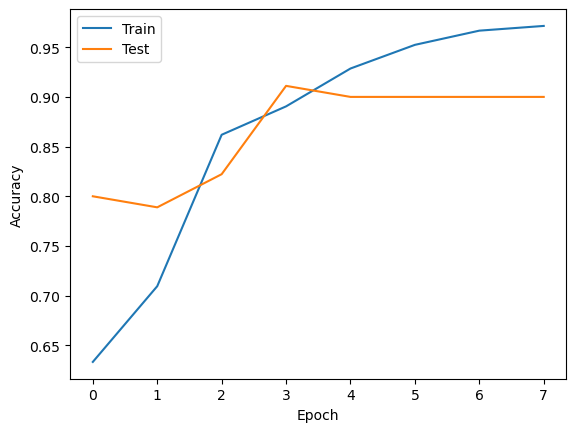

CNN Model training time = 311.92071890830994 seconds


In [32]:
cnn_start_time=time.time()
# Train the CNN model
cnn_model = model.fit(x_train, y_train, epochs=8, validation_data=(x_test, y_test))

cnn_end_time=time.time()
#plot the accuracy of the model against the accuracy of the validated data

plt.plot(cnn_model.history['accuracy'])
plt.plot(cnn_model.history['val_accuracy'])
plt.plot(cnn_model.history['loss'])
plt.plot(cnn_model.history['val_loss'])
plt.legend(['Train','Test'], loc='upper left')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

cnn_exec_time=cnn_end_time - cnn_start_time
print(f"CNN Model training time = {cnn_exec_time} seconds")

In [34]:
#save the model

save_path = os.path.join(dir_dat,'cnn_model.h5')
cnn_model_trained=cnn_model.model
# Save the CNN model at the specified location
cnn_model_trained.save(save_path)

In [35]:
# Get the trained model from the history object
trained_model = cnn_model.model
cnn_y_probs=trained_model.predict(x_test)
cnn_y_probs

3/3 [==============================] - 4s 1s/step


array([[1.67467862e-01],
       [4.77444269e-02],
       [2.92406939e-02],
       [1.00000000e+00],
       [9.98858571e-01],
       [1.18687910e-06],
       [1.54881785e-03],
       [4.57625166e-02],
       [1.00000000e+00],
       [9.71010522e-05],
       [2.59319805e-02],
       [3.54733706e-01],
       [1.00000000e+00],
       [5.12631416e-01],
       [1.55552551e-01],
       [9.99913216e-01],
       [1.00000000e+00],
       [8.28528404e-03],
       [2.65236451e-07],
       [2.86839724e-01],
       [1.51244760e-01],
       [9.97312129e-01],
       [9.99977887e-01],
       [1.39563352e-01],
       [3.01558495e-04],
       [9.99988914e-01],
       [9.99996245e-01],
       [9.99990284e-01],
       [2.08802362e-06],
       [9.83298004e-01],
       [1.03221880e-02],
       [8.96642506e-01],
       [9.99993443e-01],
       [1.37098625e-01],
       [3.83431688e-02],
       [1.77840466e-05],
       [6.09686673e-01],
       [1.95690609e-06],
       [2.77638659e-02],
       [3.94519884e-03],


In [36]:
# Define a threshold
threshold = 0.5  # You can adjust this threshold as needed

# Convert probabilities to binary classification labels
cnn_y_pred = (cnn_y_probs > threshold).astype(int)

# Print the binary classification labels
print("Binary classification labels:", cnn_y_pred)

Binary classification labels: [[0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]]


In [37]:
print(f"accuracy of CNN - {trained_model.evaluate(x_test, y_test)}")

3/3 [==============================] - 3s 1s/step - loss: 0.3594 - accuracy: 0.9000
accuracy of CNN - [0.3594149351119995, 0.8999999761581421]


In [44]:
from sklearn.metrics import f1_score
f1 = f1_score(y_test, cnn_y_pred )

# Print the F1 score
print("F1 Score:", f1)

F1 Score: 0.8571428571428571


### Random Forest Model

In [38]:
# Flatten the image data
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

In [39]:
clf = RandomForestClassifier(n_estimators=100, random_state=100)
clf.fit(x_train_flat, y_train)

RandomForestClassifier(random_state=100)

In [40]:
# Predict on the test set
y_pred = clf.predict(x_test_flat)

In [45]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

f1_rf=f1_score(y_test, y_pred)
print("F1 Score:",f1_rf)

Accuracy: 0.7777777777777778
F1 Score: 0.6875


In [ ]:
## Compute and compare CNN and RF

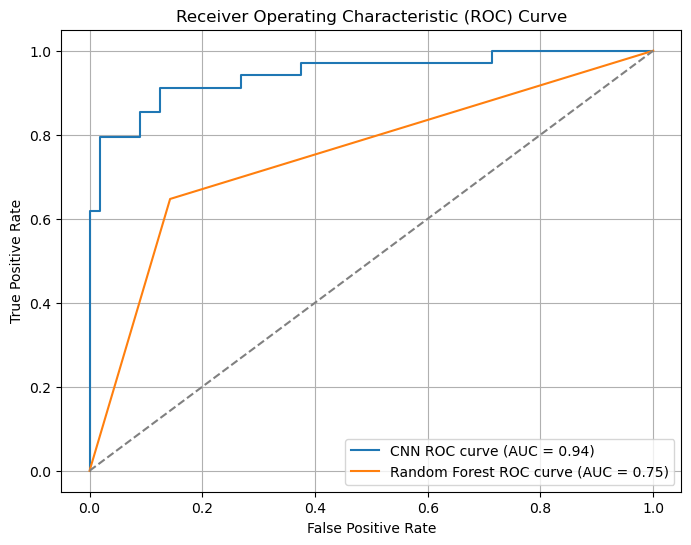

In [42]:
# Compute ROC curve and ROC AUC score
cnn_fpr, cnn_tpr, cnn_thresholds = roc_curve(y_test, cnn_y_probs)
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, y_pred)

cnn_roc_auc = roc_auc_score(y_test, cnn_y_probs)
rf_roc_auc = roc_auc_score(y_test, y_pred)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(cnn_fpr, cnn_tpr, label=f'CNN ROC curve (AUC = {cnn_roc_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, label=f'Random Forest ROC curve (AUC = {rf_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()

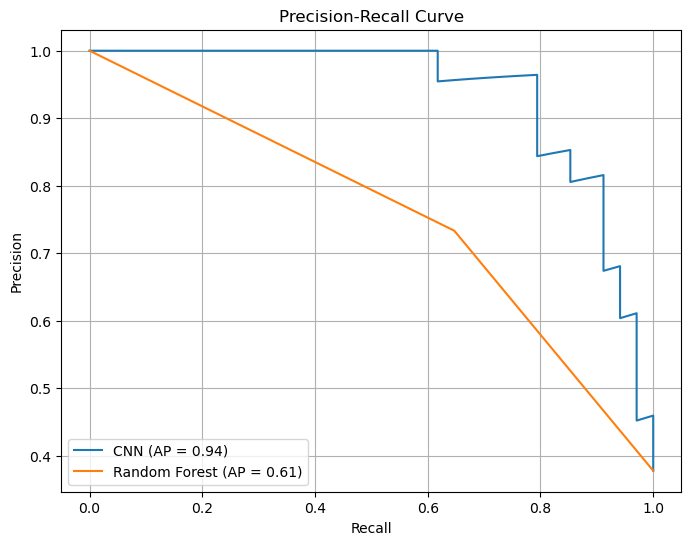

In [43]:
#Plot PRC
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# Compute precision-recall curve for CNN
cnn_precision, cnn_recall, _ = precision_recall_curve(y_test, cnn_y_probs)
cnn_ap = average_precision_score(y_test, cnn_y_probs)

# Compute precision-recall curve for Random Forest
rf_precision, rf_recall, _ = precision_recall_curve(y_test, y_pred)
rf_ap = average_precision_score(y_test, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(cnn_recall, cnn_precision, label=f'CNN (AP = {cnn_ap:.2f})')
plt.plot(rf_recall, rf_precision, label=f'Random Forest (AP = {rf_ap:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

### performing classification and copying all PHI classified files to a folder

In [46]:

image_file_loc=[]

image_file_loc=list(map(lambda x:folder_ds_name_path  +'/' + x, image_files))

image_file_loc

['/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028178_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028181_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028182_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028184_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028186_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028187_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028191_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028192_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028205_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028211_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028215_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028216_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/Image Dataset/00028223_000.png',

In [49]:
#### Select the location of the files to be classified and preprocess them

prompter = promptlib.Files()
files_loc_folder=prompter.dir()

#read the file names and store them in a list

file_names=sorted([file for file in os.listdir(files_loc_folder)if not file.endswith(".csv")])


files_path=list(map(lambda x:files_loc_folder  +'/' + x, file_names))

files_path


['/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028174_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028175_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028176_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028177_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028178_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028179_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028180_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028181_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028182_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028183_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_CLASSIFIED/00028184_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_B

In [50]:
img_classify=[]
#img_classify_arr
for im in files_path:
    #open the image and store it in the image list
    #file_name_path=os.path.join(folder_ds_name_path,im)
    img_cl=cv2.imread(im)
    
    if img_cl is None:
        print(f"Error: Unable to load image file '{file_name_path}'. Skipping...")
        continue

    #preprocess the image and normalize pixel values
    img_cl=cv2.resize(img_cl,(512,512))
    img_cl=img_cl/255
    img_classify.append(img_cl)

img_classify_arr=np.array(img_classify)    

In [51]:
# Predict probabilities for each image
probabilities = cnn_model_trained.predict(img_classify_arr)

# Classify images based on probabilities
classified_images = [(img_file, probability) for img_file, probability in zip(files_path, probabilities)]

33/33 [==============================] - 47s 1s/step


In [52]:
# Define a threshold for classification
threshold = 0.5

# Create a folder for images classified as 1
output_folder = '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
    
for img_file, probability in classified_images:
    if probability >= threshold:
        # Move the image to the output folder
        shutil.copy(img_file, os.path.join(output_folder, os.path.basename(img_file)))    

## TEST THE OCR

#### create a list of all files with PHI and pick 50 random files for testing the OCRs

In [53]:
phi_dict={}
for key, value in phi_data_dict.items():
    if value != [0]:
        phi_dict[key] = value

phi_keys=list(phi_dict.keys())
random.shuffle(phi_keys)
test_ocr_file_keys=sorted(phi_keys[:50])
test_ocr_file_keys

['00028181_000.png',
 '00028234_000.png',
 '00028254_000.png',
 '00028256_000.png',
 '00028292_000.png',
 '00028337_000.png',
 '00028368_000.png',
 '00028373_000.png',
 '00028391_000.png',
 '00028406_000.png',
 '00028412_000.png',
 '00028425_000.png',
 '00028442_000.png',
 '00028443_000.png',
 '00028464_000.png',
 '00028473_000.png',
 '00028492_000.png',
 '00028494_000.png',
 '00028509_000.png',
 '00028511_000.png',
 '00028512_000.png',
 '00028530_000.png',
 '00028604_000.png',
 '00028626_000.png',
 '00028654_000.png',
 '00028661_000.png',
 '00028670_000.png',
 '00028675_000.png',
 '00028681_000.png',
 '00028704_000.png',
 '00028736_000.png',
 '00028752_000.png',
 '00028755_000.png',
 '00028808_000.png',
 '00028813_000.png',
 '00028889_000.png',
 '00028893_000.png',
 '00028918_000.png',
 '00028932_000.png',
 '00028979_000.png',
 '00028994_000.png',
 '00029041_000.png',
 '00029077_000.png',
 '00029087_000.png',
 '00029138_000.png',
 '00029142_000.png',
 '00030751_000.png',
 '00030769_00

#### function to count the PHI data points in each file

In [54]:

def element_count(dict_name):
    

    # Initialize the total count
    total_count = 0
    count_dict={}
    # Iterate over each key in the dictionary
    for key, value in dict_name.items():
        # Count the elements of the current key
        count = len(value)
        #print(f"Number of elements in {key}: {count}")
        count_dict[key]=count
    
        # Add the count to the total count
        total_count += count

    # Display the sum of all counts
    #print(f"Sum of all counts: {total_count}")
    return(count_dict, total_count)

#### count the PHIs present in the fake dataset generated to create images with Fake PHI

In [55]:
## fetch the phi info for the 50 selected image files and save them in a dictionary

fake_test_ocr_dict={}

for key in test_ocr_file_keys:
    fake_test_ocr_dict[key]=phi_data_dict[key]
    
fake_test_ocr_dict    

{'00028181_000.png': ['address'],
 '00028234_000.png': ['Facility',
  'Name',
  'Test Date',
  'Sex',
  'ssn',
  'dob',
  'patient_id',
  'address',
  'email',
  'phone'],
 '00028254_000.png': ['dob',
  'ssn',
  'medical_rec_num',
  'address',
  'patient_id',
  'email',
  'Name',
  'phone',
  'Facility'],
 '00028256_000.png': ['medical_rec_num',
  'address',
  'Sex',
  'patient_id',
  'Facility',
  'email',
  'phone',
  'Test Date'],
 '00028292_000.png': ['ssn',
  'email',
  'Facility',
  'Sex',
  'address',
  'medical_rec_num',
  'patient_id',
  'dob',
  'phone',
  'Test Date'],
 '00028337_000.png': ['phone'],
 '00028368_000.png': ['address',
  'patient_id',
  'email',
  'Sex',
  'medical_rec_num',
  'dob',
  'Facility',
  'Name',
  'phone',
  'ssn',
  'Test Date'],
 '00028373_000.png': ['phone',
  'patient_id',
  'Test Date',
  'medical_rec_num',
  'email',
  'address',
  'Name',
  'dob'],
 '00028391_000.png': ['Name',
  'patient_id',
  'Test Date',
  'dob',
  'medical_rec_num',
  'p

In [56]:
fake_phi_dict_counts, total_fake_phi_count=element_count(fake_test_ocr_dict )

print(f" total Phi count ={total_fake_phi_count}")
fake_phi_dict_counts

 total Phi count =305


{'00028181_000.png': 1,
 '00028234_000.png': 10,
 '00028254_000.png': 9,
 '00028256_000.png': 8,
 '00028292_000.png': 10,
 '00028337_000.png': 1,
 '00028368_000.png': 11,
 '00028373_000.png': 8,
 '00028391_000.png': 6,
 '00028406_000.png': 6,
 '00028412_000.png': 7,
 '00028425_000.png': 10,
 '00028442_000.png': 7,
 '00028443_000.png': 8,
 '00028464_000.png': 10,
 '00028473_000.png': 8,
 '00028492_000.png': 3,
 '00028494_000.png': 5,
 '00028509_000.png': 6,
 '00028511_000.png': 5,
 '00028512_000.png': 7,
 '00028530_000.png': 9,
 '00028604_000.png': 9,
 '00028626_000.png': 10,
 '00028654_000.png': 11,
 '00028661_000.png': 1,
 '00028670_000.png': 4,
 '00028675_000.png': 11,
 '00028681_000.png': 2,
 '00028704_000.png': 2,
 '00028736_000.png': 6,
 '00028752_000.png': 3,
 '00028755_000.png': 10,
 '00028808_000.png': 8,
 '00028813_000.png': 5,
 '00028889_000.png': 2,
 '00028893_000.png': 6,
 '00028918_000.png': 1,
 '00028932_000.png': 2,
 '00028979_000.png': 5,
 '00028994_000.png': 6,
 '00029

### EasyOCR

In [57]:

# Initialize EasyOCR reader
ocr_reader = easyocr.Reader(['en'])

#dictionary to capture the phi present in the file

easy_ocr_phi_dict={}

easyocr_start_time=time.time()
for key in test_ocr_file_keys:
    file_path=folder_ds_name_path +'/' + key
    
    # Read text from an image (replace 'image_path.jpg' with the path to your image)
    
    text_found = ocr_reader.readtext(file_path)
    
    # Check if the keyword is present in the text
    keyword_found = False
    phi_pres_list=[]
    for phi in phi_list:
        keyword_found = False
        for detection in text_found:
            text = detection[1]
            if phi in text:
                keyword_found = True
                phi_pres_list.append(phi)
                break
                
    
    easy_ocr_phi_dict[key]=phi_pres_list

easyocr_end_time=time.time()

easy_ocr_phi_dict

[2024-04-28 22:16:04,974] [ WARNING] easyocr.py:80 - Neither CUDA nor MPS are available - defaulting to CPU. Note: This module is much faster with a GPU.


{'00028181_000.png': ['address'],
 '00028234_000.png': ['patient_id', 'Name', 'dob', 'phone', 'email', 'ssn'],
 '00028254_000.png': ['patient_id',
  'Name',
  'dob',
  'phone',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028256_000.png': ['patient_id',
  'phone',
  'email',
  'address',
  'medical_rec_num'],
 '00028292_000.png': ['patient_id', 'dob', 'phone', 'email', 'address', 'ssn'],
 '00028337_000.png': ['phone'],
 '00028368_000.png': ['patient_id',
  'dob',
  'phone',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028373_000.png': ['patient_id',
  'Name',
  'dob',
  'phone',
  'email',
  'address',
  'medical_rec_num'],
 '00028391_000.png': ['patient_id', 'dob', 'phone', 'medical_rec_num'],
 '00028406_000.png': ['Name', 'dob', 'medical_rec_num'],
 '00028412_000.png': ['Name',
  'dob',
  'phone',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028425_000.png': ['patient_id',
  'Name',
  'dob',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028

In [58]:
easy_ocr_dict_phi={}
easy_ocr_dict_phi, easy_ocr_dict_count=element_count(easy_ocr_phi_dict)
easyocr_exec_time= round((easyocr_end_time - easyocr_start_time),3)
print(f" EasyOCR total_count= {easy_ocr_dict_count}")

print(f" EasyOCR Execution Time= {easyocr_exec_time} seconds")
easy_ocr_dict_phi

 EasyOCR total_count= 211
 EasyOCR Execution Time= 564.284 seconds


{'00028181_000.png': 1,
 '00028234_000.png': 6,
 '00028254_000.png': 8,
 '00028256_000.png': 5,
 '00028292_000.png': 6,
 '00028337_000.png': 1,
 '00028368_000.png': 7,
 '00028373_000.png': 7,
 '00028391_000.png': 4,
 '00028406_000.png': 3,
 '00028412_000.png': 6,
 '00028425_000.png': 7,
 '00028442_000.png': 5,
 '00028443_000.png': 6,
 '00028464_000.png': 7,
 '00028473_000.png': 5,
 '00028492_000.png': 2,
 '00028494_000.png': 5,
 '00028509_000.png': 5,
 '00028511_000.png': 2,
 '00028512_000.png': 6,
 '00028530_000.png': 5,
 '00028604_000.png': 0,
 '00028626_000.png': 7,
 '00028654_000.png': 8,
 '00028661_000.png': 1,
 '00028670_000.png': 3,
 '00028675_000.png': 8,
 '00028681_000.png': 2,
 '00028704_000.png': 2,
 '00028736_000.png': 4,
 '00028752_000.png': 3,
 '00028755_000.png': 7,
 '00028808_000.png': 6,
 '00028813_000.png': 5,
 '00028889_000.png': 2,
 '00028893_000.png': 4,
 '00028918_000.png': 1,
 '00028932_000.png': 1,
 '00028979_000.png': 3,
 '00028994_000.png': 4,
 '00029041_000.p

### Paddle OCR

In [59]:
#initialize paddle ocr


paddle_ocr=PaddleOCR()

paddle_ocr_dict={}

#test_ocr_file_keys_1=test_ocr_file_keys[1]

start_time=time.time()
for key in test_ocr_file_keys:

    # append the folder path to the file names
    file_path=folder_ds_name_path +'/' + key

    
    # Read the image
    img = cv2.imread(file_path)

    # Read the text using PaddleOCR
    paddle_result = paddle_ocr.ocr(img)

    # Extract the text
    paddle_text = []

    
    if paddle_result is not None:
        recognized_text=''
        for line in paddle_result:
            line_text = ''
            for word_detail in line:
                line_text += word_detail[1][0] + ' '  # Extract the text from the tuple and concatenate with a space
            recognized_text += line_text.strip() + '\n'  # Remove trailing space and add a newline after each line

        for phi in phi_list:
            if phi in recognized_text:
                paddle_text.append(phi)
            
            
    paddle_ocr_dict[key]=paddle_text
        
        
end_time=time.time()        

In [60]:

paddle_ocr_dict_phi, paddle_ocr_dict_count=element_count(paddle_ocr_dict)
paddleocr_exec_time=round((end_time - start_time),3)
print(f"Paddle OCR total_count= {paddle_ocr_dict_count}")
print(f"Execution Time: {paddleocr_exec_time} seconds")
paddle_ocr_dict_phi

Paddle OCR total_count= 214
Execution Time: 127.435 seconds


{'00028181_000.png': 1,
 '00028234_000.png': 6,
 '00028254_000.png': 8,
 '00028256_000.png': 5,
 '00028292_000.png': 7,
 '00028337_000.png': 1,
 '00028368_000.png': 7,
 '00028373_000.png': 7,
 '00028391_000.png': 4,
 '00028406_000.png': 3,
 '00028412_000.png': 6,
 '00028425_000.png': 7,
 '00028442_000.png': 5,
 '00028443_000.png': 6,
 '00028464_000.png': 7,
 '00028473_000.png': 6,
 '00028492_000.png': 3,
 '00028494_000.png': 5,
 '00028509_000.png': 5,
 '00028511_000.png': 2,
 '00028512_000.png': 6,
 '00028530_000.png': 6,
 '00028604_000.png': 0,
 '00028626_000.png': 7,
 '00028654_000.png': 8,
 '00028661_000.png': 1,
 '00028670_000.png': 3,
 '00028675_000.png': 8,
 '00028681_000.png': 2,
 '00028704_000.png': 2,
 '00028736_000.png': 4,
 '00028752_000.png': 3,
 '00028755_000.png': 7,
 '00028808_000.png': 6,
 '00028813_000.png': 5,
 '00028889_000.png': 2,
 '00028893_000.png': 4,
 '00028918_000.png': 1,
 '00028932_000.png': 1,
 '00028979_000.png': 2,
 '00028994_000.png': 3,
 '00029041_000.p

### pytesseract OCR

In [61]:
pytes_ocr_dict={}

pytes_ocr_start_time=time.time()

for key in test_ocr_file_keys:

    # append the folder path to the file names
    file_path=folder_ds_name_path +'/' + key
    
    #list to capture PHIs for the file
    pytes_txt_list=[]
    
    # Open the image file
    with Image.open(file_path) as img:
        # Use pytesseract to perform OCR on the image
        pytes_text= pytesseract.image_to_string(img)
        
        for phi in phi_list:
            if phi in pytes_text:
                pytes_txt_list.append(phi)
                
    pytes_ocr_dict[key]=pytes_txt_list


pytes_ocr_end_time=time.time()

python(38819) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38820) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38822) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38823) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38824) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38825) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38826) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38827) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38830) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38831) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(38832) Malloc

In [62]:
pytes_ocr_dict_phi, pytes_ocr_dict_count=element_count(pytes_ocr_dict)
pytes_ocr_exec_time=round((pytes_ocr_end_time - pytes_ocr_start_time),3)
print(f"Paddle OCR total_count= {pytes_ocr_dict_count}")
print(f"Execution Time: {pytes_ocr_exec_time} seconds")
pytes_ocr_dict_phi

Paddle OCR total_count= 82
Execution Time: 23.252 seconds


{'00028181_000.png': 1,
 '00028234_000.png': 2,
 '00028254_000.png': 3,
 '00028256_000.png': 4,
 '00028292_000.png': 4,
 '00028337_000.png': 1,
 '00028368_000.png': 0,
 '00028373_000.png': 0,
 '00028391_000.png': 3,
 '00028406_000.png': 1,
 '00028412_000.png': 3,
 '00028425_000.png': 1,
 '00028442_000.png': 3,
 '00028443_000.png': 2,
 '00028464_000.png': 1,
 '00028473_000.png': 0,
 '00028492_000.png': 0,
 '00028494_000.png': 0,
 '00028509_000.png': 5,
 '00028511_000.png': 1,
 '00028512_000.png': 6,
 '00028530_000.png': 4,
 '00028604_000.png': 0,
 '00028626_000.png': 1,
 '00028654_000.png': 1,
 '00028661_000.png': 1,
 '00028670_000.png': 1,
 '00028675_000.png': 6,
 '00028681_000.png': 1,
 '00028704_000.png': 1,
 '00028736_000.png': 3,
 '00028752_000.png': 1,
 '00028755_000.png': 3,
 '00028808_000.png': 0,
 '00028813_000.png': 0,
 '00028889_000.png': 1,
 '00028893_000.png': 3,
 '00028918_000.png': 1,
 '00028932_000.png': 1,
 '00028979_000.png': 2,
 '00028994_000.png': 2,
 '00029041_000.p

### Semantic Tagging

In [81]:
### Perform Semantic tagging of files using Paddle OCR

paddle_ocr=PaddleOCR()

semantic_file_tag={}


#fetch the files from the folder where all PHI classified files are present

phi_classified_files=sorted([file for file in os.listdir(output_folder)if file.lower().endswith(('.png', '.jpeg', '.jpg'))])
                            
phi_classified_files_path=list(map(lambda x:output_folder  +'/' + x, phi_classified_files))

phi_classified_files_path

['/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028180_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028181_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028183_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028184_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028190_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028191_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028198_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028204_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028207_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028212_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028227_000.png',
 '/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028255_00

In [82]:


for key in phi_classified_files:

    # append the folder path to the file names
    cl_file_path= output_folder +'/' + key

    print(f"{cl_file_path}")
    # Read the image
    img = cv2.imread( cl_file_path)

    # Read the text using PaddleOCR
    paddle_result = paddle_ocr.ocr(img)

    # Extract the text
    paddle_text = []

    
    if paddle_result is not None:
        recognized_text=''
        for line in paddle_result:
            
            if line is not None:
                line_text = ''
                for word_detail in line:
                    line_text += word_detail[1][0] + ' '  # Extract the text from the tuple and concatenate with a space
                recognized_text += line_text.strip() + '\n'  # Remove trailing space and add a newline after each line

        for phi in phi_list:
            if phi in recognized_text:
                paddle_text.append(phi)
            
            
    semantic_file_tag[key]=paddle_text
    
    
semantic_file_tag

/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028180_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028181_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028183_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028184_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028190_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028191_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028198_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028204_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028207_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028212_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028227_000.png
/Users/abhishekalexander/Desktop/Capstone/FILES_TO_BE_REDACTED/00028255_000.png
/Users/abhishekalexander/Desktop/Capston

{'00028180_000.png': ['patient_id',
  'Name',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028181_000.png': ['Name', 'phone', 'medical_rec_num'],
 '00028183_000.png': ['Name', 'phone', 'email', 'address', 'ssn'],
 '00028184_000.png': ['Name', 'dob', 'phone', 'address', 'medical_rec_num'],
 '00028190_000.png': ['Name',
  'dob',
  'phone',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028191_000.png': ['patient_id',
  'Name',
  'dob',
  'phone',
  'email',
  'address',
  'ssn'],
 '00028198_000.png': ['Name', 'dob', 'phone', 'email', 'address', 'ssn'],
 '00028204_000.png': ['patient_id', 'Name', 'email', 'ssn'],
 '00028207_000.png': [],
 '00028212_000.png': [],
 '00028227_000.png': ['patient_id', 'Name', 'dob', 'phone', 'address'],
 '00028255_000.png': ['patient_id',
  'dob',
  'phone',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028260_000.png': ['patient_id',
  'Name',
  'dob',
  'phone',
  'email',
  'address',
  'ssn',
  'medical_rec_num'],
 '00028262_00

In [78]:
#saving the semantic tagging dictionary as a csv file
df=pd.DataFrame(list(semantic_file_tag.items()),columns=['file_name','PHI_Tags'])

sem_tag_file_loc=output_folder+'/semantic_tagging_file.csv'

df.to_csv(sem_tag_file_loc, index=False)

### Perform Data Redaction

In [85]:
def redact_data(file_keys, phi_list):
    
    # Initialize PaddleOCR
    ocr = PaddleOCR()
    
    dest_path=dir_dat + '/REDACTED_FILES'
    
    
    output_folder = dir_dat + '/FILES_TO_BE_REDACTED'
    phi_classified_files=sorted([file for file in os.listdir(output_folder)if file.lower().endswith(('.png', '.jpeg', '.jpg'))])
    
    redacted_color = (0, 0, 256)  # red color for redaction
    
    for key in file_keys:
        
        image_path = output_folder +'/' + key
        
        redacted_image_path=  dest_path + '/' + os.path.splitext(key)[0] + '_redacted.png'
        
        
        # Perform OCR
        result = ocr.ocr(image_path)

        redacted_image = cv2.imread(image_path)
        
        
        
        if result is not None:
            for line in result: 

                for word_info in line:
                    # Extract recognized text
                
                    text = word_info[1][0]


                    # Check if the text contains any of the keywords
                    for keyword in phi_list:
                        if (keyword in text):
   
                            # Extract bounding box coordinates
                            bbox = word_info[0]
                            x_min, y_min = map(int, [bbox[0][0], bbox[0][1]])
                            x_max, y_max = map(int, [bbox[2][0], bbox[2][1]])
            
                            # Draw a red rectangle to redact the text
                            cv2.rectangle(redacted_image, (x_min, y_min), (x_max, y_max), redacted_color, -1)
                    
                    
        # Save the redacted image
        
        cv2.imwrite(redacted_image_path, redacted_image)

In [86]:
redact_data(phi_classified_files, phi_list)

TypeError: 'NoneType' object is not iterable